# Notebook for the ai training of an ai golf swing analyzer

In [1]:
import torch
from torchsummary import summary

from data.dataloader import SwingDataset
from utils.models import BaselineModel
from torch.utils.data import DataLoader, Subset

from timeit import default_timer as timer

import os
import numpy as np
import matplotlib.pyplot as plt
import albumentations as A
import cv2

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [3]:
BATCH_SIZE = 32
input_size = (480, 640)
output_size = (134, 174)

transform_shared = A.Compose([
    A.Normalize(normalization='image'),
], is_check_shapes=False)

transform_image = A.Compose([
    A.Resize(height=input_size[0], width=input_size[1]),
])

In [4]:
def image2u8(image_in):
    image_min = np.min(image_in)
    image_max = np.max(image_in)
    
    # Prevent division by zero
    if image_max - image_min == 0:
        return np.zeros_like(image_in, dtype=np.uint8)

    image_out = (image_in - image_min) / (image_max - image_min)
    image_out = (image_out * 255).astype(np.uint8)

    return image_out

In [5]:
# Creating the dataloader
labels_name = [
    "r ankle",
    "r klnee",
    "r hip",
    "l hip",
    "l knee", 
    "l ankle",
    "pelvis", 
    "thorax", 
    "upper neck", 
    "head top", 
    "r wrist",
    "r elbow",
    "r shoulder",
    "l shoulder",
    "l elbow",
    "l wrist"
]

dataset = SwingDataset("data/annotations/train.json", "data", transform=transform_shared, im_transform=transform_image)
dataloader = DataLoader(dataset, shuffle=True, batch_size=BATCH_SIZE)

small_indices = list(range(10))
small_dataset = Subset(dataset, small_indices)

small_loader = DataLoader(small_dataset, batch_size=4, shuffle=True)

In [6]:
image, target = next(iter(small_loader))

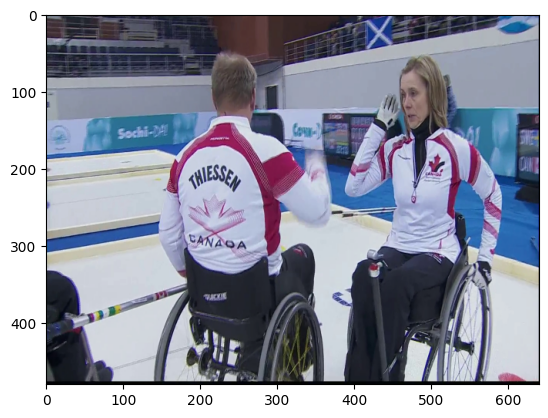

tensor(0.9961)


In [7]:
plt.imshow(image2u8(image[0].numpy()))
plt.show()
print(target[0,0].max())

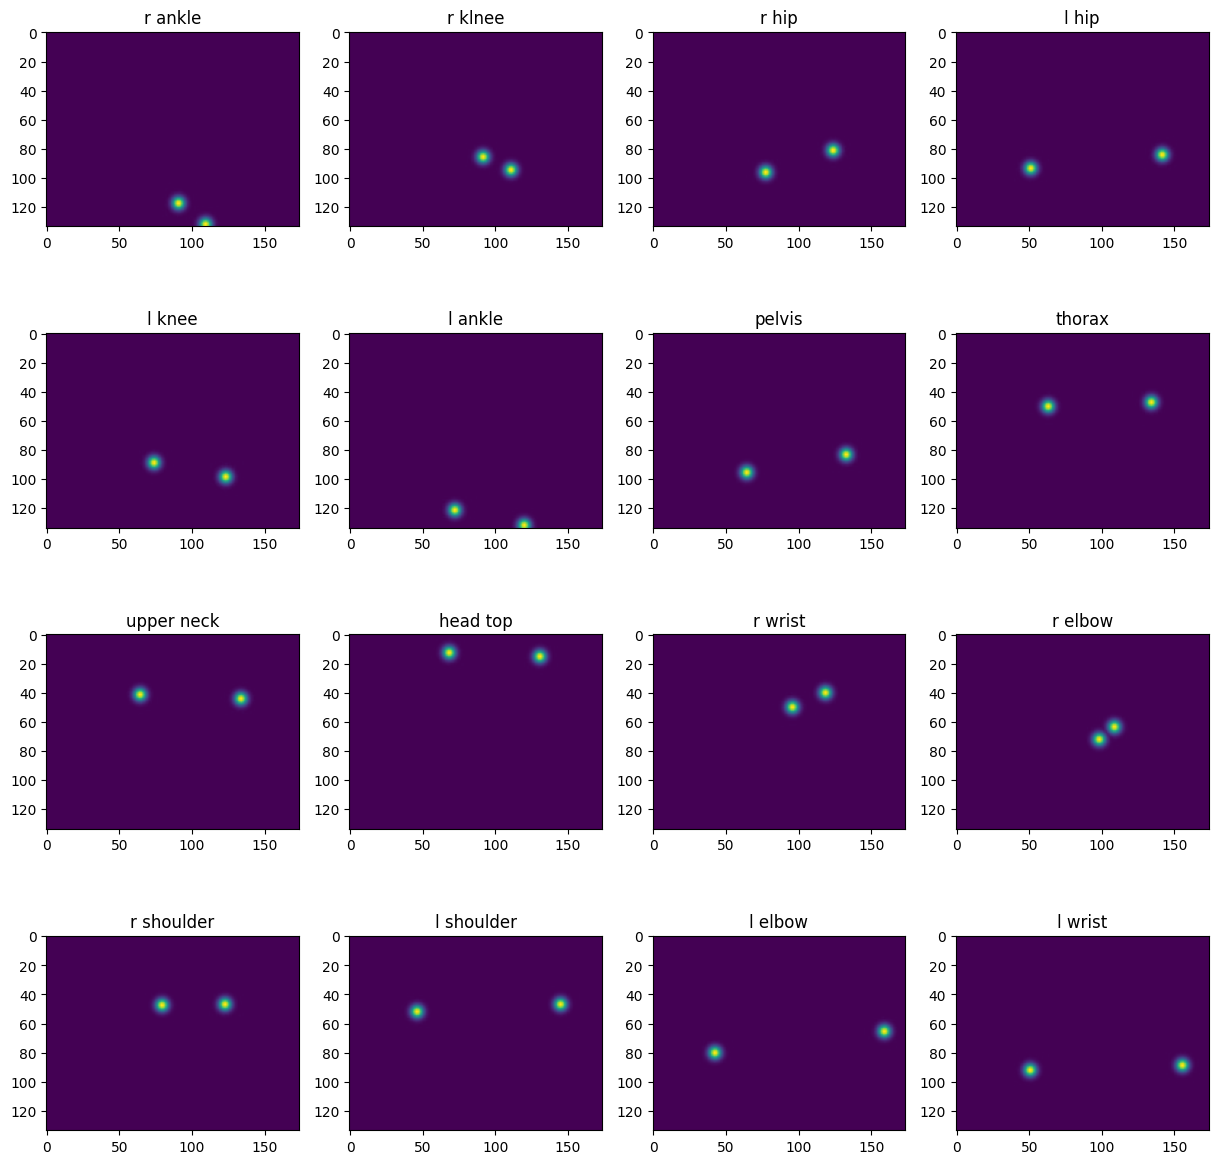

In [8]:
fig, axs = plt.subplots(4, 4, figsize=(15, 15))

for i in range(4):
    for j in range(4):
        axs[i,j].imshow(target[0, i*4 + j])
        axs[i,j].set_title(labels_name[i*4 + j])

In [11]:
# Instantiate the model

model = BaselineModel(num_keypoints=16)
model.to(device)
inp = torch.zeros([5,3,input_size[0],input_size[1]]).to(device)
sample = model(inp)

summary(model, (3,input_size[0],input_size[1]))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 240, 320]           9,408
       BatchNorm2d-2         [-1, 64, 240, 320]             128
              ReLU-3         [-1, 64, 240, 320]               0
         MaxPool2d-4         [-1, 64, 120, 160]               0
            Conv2d-5         [-1, 64, 120, 160]          36,864
       BatchNorm2d-6         [-1, 64, 120, 160]             128
              ReLU-7         [-1, 64, 120, 160]               0
            Conv2d-8         [-1, 64, 120, 160]          36,864
       BatchNorm2d-9         [-1, 64, 120, 160]             128
             ReLU-10         [-1, 64, 120, 160]               0
       BasicBlock-11         [-1, 64, 120, 160]               0
           Conv2d-12         [-1, 64, 120, 160]          36,864
      BatchNorm2d-13         [-1, 64, 120, 160]             128
             ReLU-14         [-1, 64, 1

In [10]:
# Charger le modele

model = torch.load('data/model_6000iters.pth', weights_only=False)

In [12]:
def train_step(inputs, labels, model, optim, loss_fn):
    model.train()

    # Permute from (B, H, W, C) to (B, C, H, W) and send to device
    # plt.figure()
    # plt.imshow(inputs[0].numpy())
    # plt.figure()
    # plt.imshow(labels[0, 9].numpy())
    
    inputs = inputs.permute(0, 3, 1, 2).to(device)
    labels = labels.to(device)

    # Forward pass
    optim.zero_grad()
    outputs = model(inputs)
    # plt.figure()
    # plt.imshow(outputs[0, 9].detach().cpu().numpy())
    # plt.show()
    #cv2.waitKey()
   # cv2.destroyAllWindows()
    # Calculate loss on the GPU
    loss = loss_fn(outputs, labels)

    # Backward pass and optimization
    loss.backward()
    optim.step()
    
    return loss.item()

In [13]:
def eval_step(inputs, labels, model, loss_fn):
    model.eval()
    
    # Disable gradient calculation for efficiency
    with torch.no_grad():
        inputs = inputs.permute(0, 3, 1, 2).to(device)
        labels = labels.to(device)
        
        # Get model output
        outp = model(inputs)

        # Calculate loss on the GPU with the correct variable
        loss = loss_fn(outp, labels)

    return loss.item()

ITER  0: training loss       = 2.4085
______________________________________
ITER  50: training loss       = 0.1214
______________________________________
ITER  100: training loss       = 0.0047
______________________________________
ITER  150: training loss       = 0.0035
______________________________________
ITER  200: training loss       = 0.0034
______________________________________
ITER  250: training loss       = 0.0029
______________________________________
ITER  300: training loss       = 0.0027
______________________________________
ITER  350: training loss       = 0.0026
______________________________________
ITER  400: training loss       = 0.0025
______________________________________
ITER  450: training loss       = 0.0024
______________________________________
ITER  500: training loss       = 0.0023
______________________________________
ITER  550: training loss       = 0.0023
______________________________________
ITER  600: training loss       = 0.0022
_______________

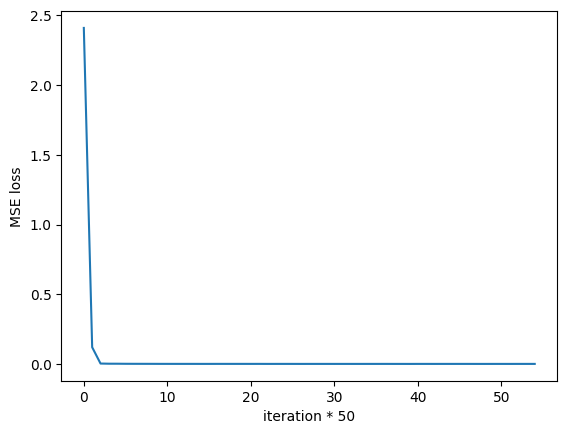

In [14]:
# Learning loop
LEARNING_RATE = 0.0001
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = torch.nn.MSELoss()

start_t = timer()

average_training_losses = []
training_losses = []
iteration = 0
nb_pts = 0 
max_iter = 10000
stop_epoch = False

for epoch in range(5): 
    for (x_train_in, y_train_in) in dataloader:

        training_losses.append(train_step(x_train_in, y_train_in, model, optimizer, criterion))
        if iteration % 50 == 0:
            nb_pts += 1 
            average_training_losses.append(sum(training_losses) / len(training_losses))
            training_losses = []
            print("ITER  {}: training loss       = {:.4f}".format(iteration, average_training_losses[-1]))
            print("______________________________________")
        if iteration >= max_iter:
            stop_epoch = True
            break
        iteration += 1            
    if stop_epoch:
        break
#TODO

end_t = timer()
print("time_elapsed: {}".format(end_t - start_t))

times = list(range(len(average_training_losses)))

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(np.arange(nb_pts), average_training_losses)
ax.set_xlabel("iteration * 50")
ax.set_ylabel("MSE loss")
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-3.2797775..0.8670524].


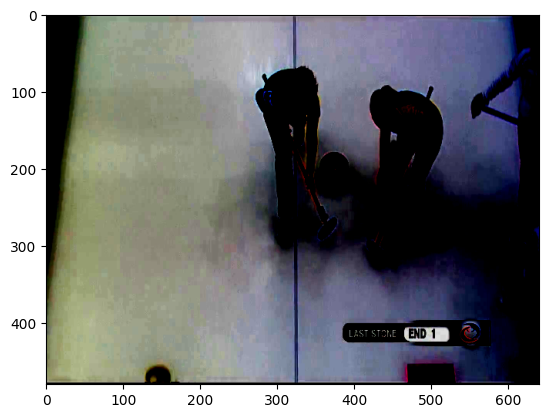

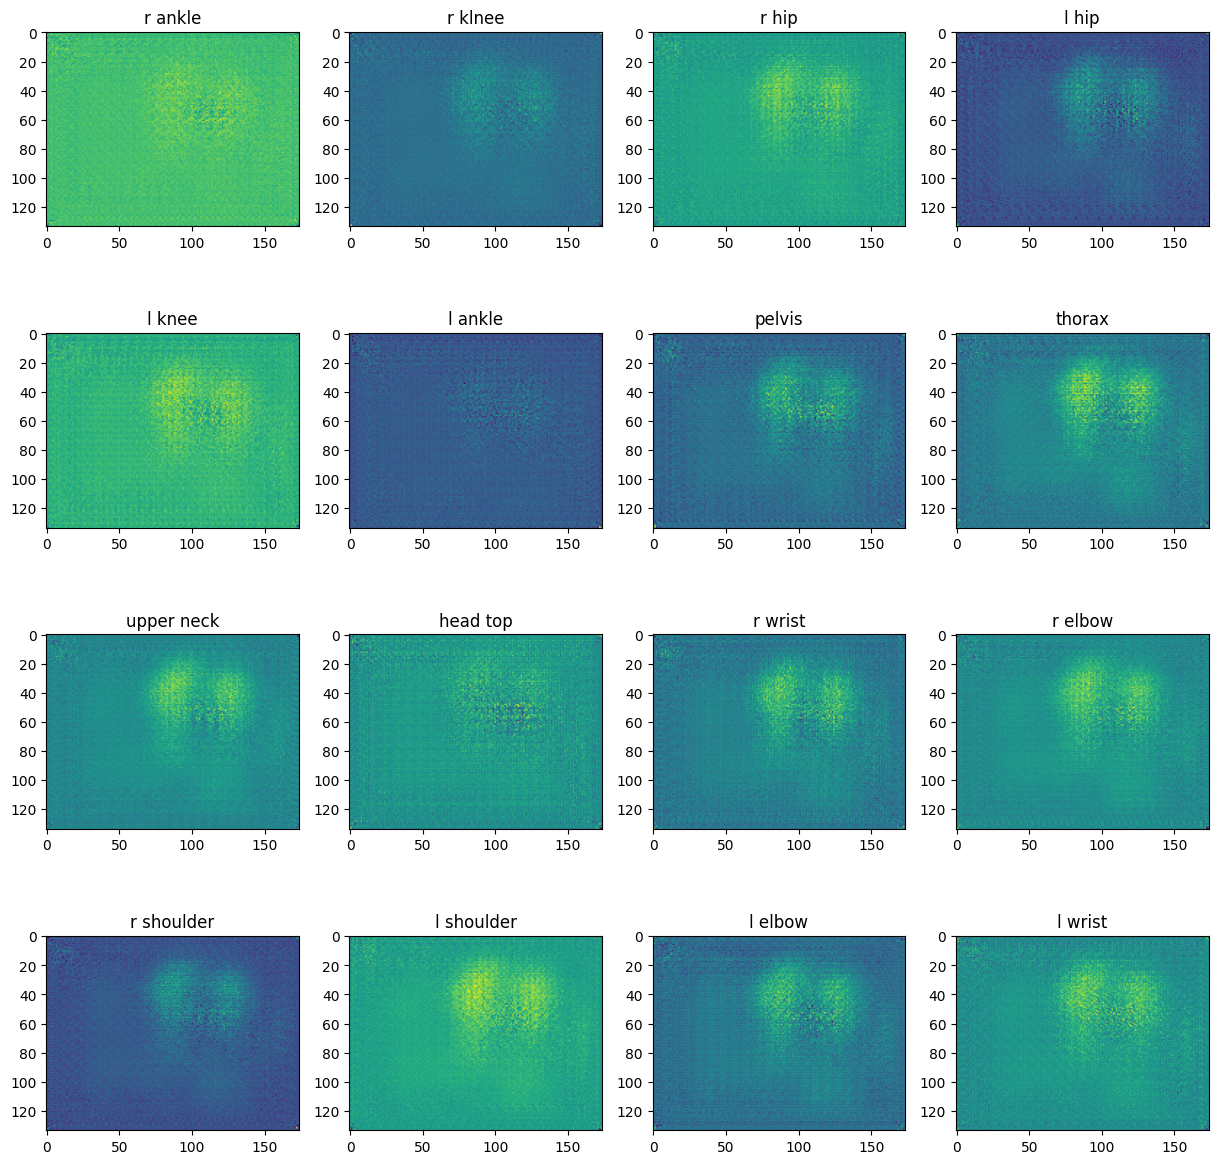

In [15]:
def inference(inputs, kp_model):
    kp_model.eval()

    inputs = inputs.permute(0, 3, 1, 2).to(device)

    outp = kp_model(inputs).detach().cpu().numpy()

    return outp


im, lab = next(iter(small_loader))
lab = lab.cpu().numpy()
result = inference(im, model)

plt.figure()
plt.imshow(im[0])

fig, axs = plt.subplots(4, 4, figsize=(15, 15))

for i in range(4):
    for j in range(4):
        axs[i,j].imshow(result[0, i*4 + j])
        axs[i,j].set_title(labels_name[i*4 + j])